# Parameterization Experiments

In this notebook, we'll illustrate the process of learning a *parameterized* form for $\Omega$ from data with true labels. 

In [21]:
using StatsBase
using Combinatorics
using Plots
using Optim

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

In [22]:
kmax = 15
H, Z = read_hypergraph_data("congress-bills",kmax)
n = 1.0*length(H.D)

1718.0

Now we'll define a parameterization. In this notebook, we'll use: 
$$\Omega(p;\alpha) = \left(\frac{p_1}{k}\right)^{\alpha_k} n^{-\alpha_0 k}\;, $$
where $k$ is the number of elements partitioned by $p$. Intuitively, he parameter $\alpha_0$ controls the absolute size scaling, while the parameters $\alpha_1,\ldots,\alpha_{kmax}$ control how the frequency of a hyperedge depends on the relative size of the plurality. Note that, although I've used the notation $\alpha_0$ for the size parameter here, in the code below it's actually the final entry of $\alpha$. 


In [27]:
function ω(p, α)
        k = sum(p)
        return (p[1] / k)^α[k]  / n^(α[end]*k)
end

# random initialization
α0 = 3*rand(kmax)
α0 = vcat(α0, 1.5)

Ω = buildΩ(ω, α0, kmax);

Next we'll optimize. The code below is VERY shaggy and VERY slow, but it captures the right general idea. Big picture: it's coordinate ascent in the entries of $\alpha$, doing nothing smart. We're just looping through an out-of-the-box solver. 

In [32]:
α = α0

ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

C       = evalCuts(Z,H)
V, μ, S = evalSums(Z,H,ℓ,true);

order = vcat([kmax+1], 1:kmax)

for i = 1:20
    res = 0
    for h = 1:length(α0)
        j = order[h]
        function objective(a)
            alph = copy(α)
            alph[j] = a[1]
            obj = 0.0
            for p in keys(S)
                Op = Ω(p; α=alph, mode="partition")
                obj -= S[p]*Op
                if p in keys(C)
                    obj += C[p]*log(Op)
                end
            end
            return -obj # for minimization
        end
        res = optimize(objective, [α[j]], LBFGS())
        α[j] = Optim.minimizer(res)[1]
    end
    println(Optim.minimum(res))
end

4.863219259562454e6
4.863091500148607e6
4.8630211112843035e6
4.862982827765676e6
4.862962208856954e6
4.862951185112626e6
4.8629453234318225e6
4.862942219112938e6
4.862940579931674e6
4.862939716258456e6
4.862939261910767e6
4.862939023167857e6
4.862938897821201e6
4.862938832050074e6
4.86293879755386e6
4.862938779464442e6
4.862938769983699e6
4.862938765014423e6
4.862938762410029e6
4.86293876104512e6


Let's plot the entries of $\alpha$ corresponding to the influence of the group plurality. 

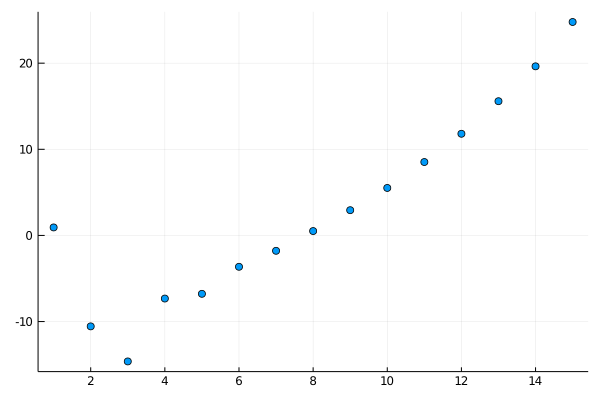

In [33]:
plot(1:kmax, α[1:kmax], seriestype = :scatter, label = "")

So, several things about this are reasonably neat. First, the value of $\alpha_k$ depends relatively smoothly on $k$. Perhaps more interesting is the fact that the small $k$ values of $\alpha$ are negative, suggesting that small groups of cosponsors actually tend to be heterogeneous. 

The strong dependence on size is worth querying further, however, and I don't fully trust these results. Considering that there's plenty of data, a better approach might be to do a similar method but with a different parameter in the dominator for each size, resulting in $2kmax$ parameters. This would allow us to check that this isn't just a model misbehavior in which the $\alpha_k$'s are actually attempting to do the work of $\alpha_0$. 